# Stage 1: Imports

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_auc_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, f1_score

In [17]:
df = pd.read_csv("datav1.csv").drop(columns=['Unnamed: 0', 'Player', 'year'])

# Stage 2: Data Preparation

In [ ]:
# Step 2.1: Create binary classification target for Step 1
df['MVP_Candidate'] = (df['Share'] > .001).astype(int)

# Step 2.1: Classification split
X_classification = df.drop(columns=['Share', 'MVP_Candidate'])
y_classification = df['MVP_Candidate']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)

# Regression split (only for MVP candidates)
df_regression = df[df['MVP_Candidate'] == 1].copy()
X_regression = df_regression.drop(columns=['Share', 'MVP_Candidate'])
y_regression = df_regression['Share']

# Define a threshold to categorize high and low MVP share
threshold = 0.3

# Add a temporary stratification column to label high and low shares
df_regression.loc[:, 'Stratified_Label'] = (y_regression > threshold).astype(int)

# Perform stratified sampling
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression,
    y_regression,
    test_size=0.2,
    random_state=42,
    stratify=df_regression['Stratified_Label']
)

# Drop the temporary column from the dataset
df_regression = df_regression.drop(columns=['Stratified_Label'])

# Stage 3 Attempt 1: Classification Model Attempt 1

In [19]:
# Step 3.1: Define a neural network model
def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),  # Dropout to prevent overfitting
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 3.2: Convert training and test sets to NumPy arrays
X_train_nn = X_train_class.values
X_test_nn = X_test_class.values
y_train_nn = y_train_class.values
y_test_nn = y_test_class.values

In [20]:
# Step 3.3: Create the model
input_dim = X_train_nn.shape[1]

model = create_model(input_dim)
early_stopping = EarlyStopping(
    monitor='val_loss',
    #patience=0,
    restore_best_weights=True
)
history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


/Users/arjunj/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8539 - loss: 0.3496 - val_accuracy: 0.9316 - val_loss: 0.1522
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.9456 - loss: 0.1456 - val_accuracy: 0.9343 - val_loss: 0.1368
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.9482 - loss: 0.1274 - val_accuracy: 0.9437 - val_loss: 0.1317
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.9500 - loss: 0.1265 - val_accuracy: 0.9410 - val_loss: 0.1231
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.9633 - loss: 0.1030 - val_accuracy: 0.9397 - val_loss: 0.1292


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       852
           1       0.61      0.85      0.71        80

    accuracy                           0.94       932
   macro avg       0.80      0.90      0.84       932
weighted avg       0.95      0.94      0.95       932

ROC-AUC: 0.9717
Recall: 0.8500
Precision: 0.6126
F1 Score: 0.7120


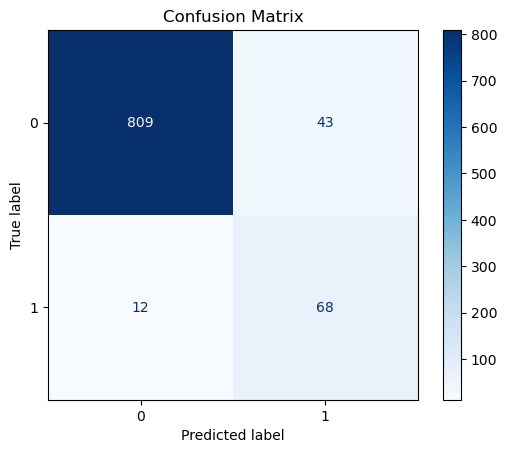

In [21]:
# Step 3.4 Evaluate the Model
# Predict probabilities and binary outcomes
y_pred_proba_nn = model.predict(X_test_nn).ravel()
y_pred_nn = (y_pred_proba_nn >= 0.3).astype(int)  # Adjust threshold for high recall

# Evaluate metrics
print("Classification Report:")
print(classification_report(y_test_nn, y_pred_nn))

roc_auc_nn = roc_auc_score(y_test_nn, y_pred_proba_nn)
recall_nn = recall_score(y_test_nn, y_pred_nn)
precision_nn = precision_score(y_test_nn, y_pred_nn)
f1_nn = f1_score(y_test_nn, y_pred_nn)

print(f"ROC-AUC: {roc_auc_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
# Generate the confusion matrix
cm = confusion_matrix(y_test_nn, y_pred_nn)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

# Add title and labels
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Step 3.5 Analyze the False Negatives
# Create a mask for false negatives
false_negative_mask = (y_test_nn == 1) & (y_pred_nn == 0)

# Extract the false negatives from the test dataset
false_negatives_df = X_test_class[false_negative_mask]

# Add the true labels and predicted probabilities to the DataFrame for context
false_negatives_df['True_Label'] = y_test_nn[false_negative_mask]
false_negatives_df['Predicted_Probability'] = y_pred_proba_nn[false_negative_mask]

print(false_negatives_df.head())
# Display the false negatives DataFrame
# Load the original data
datav1 = pd.read_csv("datav1.csv")

# Drop the columns "True_Label" and "Predicted_Probability" from false_negatives_df
columns_to_match = false_negatives_df.drop(columns=["True_Label", "Predicted_Probability"]).columns

# Filter rows from datav1 that match any row in false_negatives_df
matched_false_negatives = datav1[
    datav1.apply(
        lambda row: any(
            (false_negatives_df[columns_to_match] == row[columns_to_match].values).all(axis=1)
        ),
        axis=1
    )
]

# Display the resulting DataFrame
print("Matched False Negatives in datav1.csv:")
matched_false_negatives.to_csv("matched_false_negatives.csv", index=False)

/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_65491/518744907.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df['True_Label'] = y_test_nn[false_negative_mask]
/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_65491/518744907.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df['Predicted_Probability'] = y_pred_proba_nn[false_negative_mask]


             G        GS        MP        FG       FGA       FG%        3P  \
3159 -1.804628 -1.293099  0.404207  1.831291  2.180180 -0.933879 -0.725234   
383  -1.778555 -0.458199  1.041125  2.464337  2.643409 -0.406757 -0.454029   
4362  0.522059  0.861107  0.193093  0.993285  0.644729  0.917056 -0.677802   
1666  0.539951  0.784706  1.704801  1.939620  1.850140  0.252568  2.119591   
4503  0.855727  1.096734  0.643765  1.302167  0.717232  1.881566 -0.873544   

           3PA       3P%        2P  ...       OWS       DWS        WS  \
3159 -0.608660 -0.481748  2.239816  ... -0.839814 -0.327216 -0.824843   
383  -0.269375  0.039237  2.653385  ... -0.504596 -0.801773 -0.689416   
4362 -0.671514  0.556180  1.212161  ...  0.990339 -0.068106  0.744714   
1666  1.512902  1.232970  1.047011  ...  2.324008 -0.981639  1.332632   
4503 -0.891131 -0.498825  1.587754  ...  1.490778  0.622622  1.407793   

         WS/48      OBPM      DBPM       BPM      VORP  True_Label  \
3159 -0.774399  0.9891

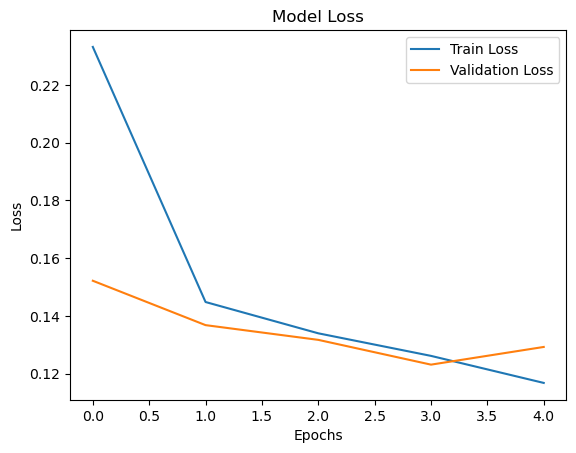

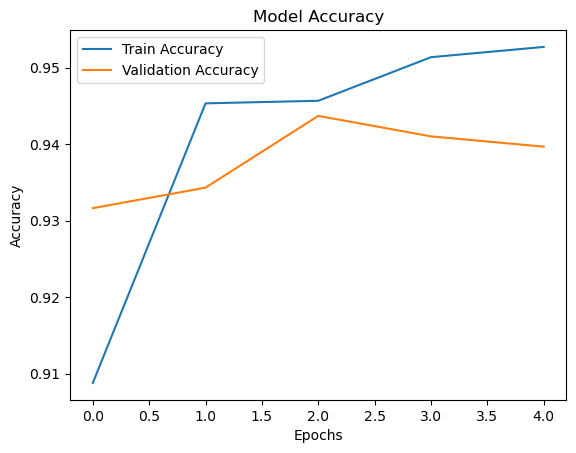

In [23]:
# Step 3.6: Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Upon further analysis, all false negative enteries got less than .0027 of the share of the mvp vote. There was only one substantial miss which was Jermaine O'Neals 2003-2004 campaing. Upon further analysis of his stats, his efficiency was incredibly poor. Likely that he only got mvp votes because he was the best player on the best team during this season. This might make me consider adding team wins, but his winshare was not incredible high

In [24]:
# Step 3.1: Create and Train the Model
# Define scale_pos_weight to address class imbalance
scale_pos_weight = len(y_train_class[y_train_class == 0]) / len(y_train_class[y_train_class == 1])

# Initialize XGBoost classifier
classifier = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc'
)

In [25]:
# Step 3.2: Train the classifier
classifier.fit(X_train_class, y_train_class)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [26]:
# Step 3.3: Evaluate the Model
# Predict probabilities and binary outcomes
y_pred_proba_xgb = classifier.predict_proba(X_test_class)[:, 1]
y_pred_xgb = (y_pred_proba_xgb >= 0.3).astype(int)  # Adjust threshold for high recall

# Print classification metrics
print("Classification Report:")
print(classification_report(y_test_class, y_pred_xgb))

# Calculate and print additional metrics
roc_auc_xgb = roc_auc_score(y_test_class, y_pred_proba_xgb)
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       852
           1       0.74      0.88      0.80        80

    accuracy                           0.96       932
   macro avg       0.86      0.92      0.89       932
weighted avg       0.97      0.96      0.96       932

ROC-AUC Score: 0.9862


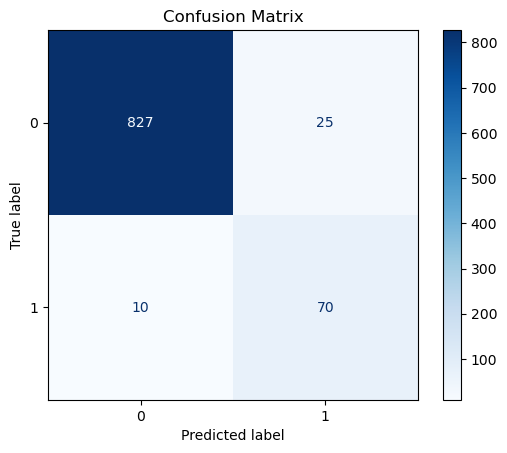

In [27]:
# Step 3.4: Plot the Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

# Add title and show the plot
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Step 3.5: Extract False Negatives
# Create a mask for false negatives
false_negative_mask = (y_test_class == 1) & (y_pred_xgb == 0)

# Extract the false negatives from the test dataset
false_negatives_df = X_test_class[false_negative_mask]

# Add the true labels and predicted probabilities for context
false_negatives_df['True_Label'] = y_test_class[false_negative_mask]
false_negatives_df['Predicted_Probability'] = y_pred_proba_xgb[false_negative_mask]

datav1 = pd.read_csv("datav1.csv")

# Drop the columns "True_Label" and "Predicted_Probability" from false_negatives_df
columns_to_match = false_negatives_df.drop(columns=["True_Label", "Predicted_Probability"]).columns

# Filter rows from datav1 that match any row in false_negatives_df
matched_false_negatives = datav1[
    datav1.apply(
        lambda row: any(
            (false_negatives_df[columns_to_match] == row[columns_to_match].values).all(axis=1)
        ),
        axis=1
    )
]
# Display the resulting DataFrame
print("Matched False Negatives in datav1.csv:")
matched_false_negatives.to_csv("matched_false_negatives.csv", index=False)

/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_65491/1207825019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df['True_Label'] = y_test_class[false_negative_mask]
/var/folders/g9/3tj7x28j4hq3r0r9fqgmfcy80000gn/T/ipykernel_65491/1207825019.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df['Predicted_Probability'] = y_pred_proba_xgb[false_negative_mask]


Matched False Negatives in datav1.csv:


# Stage 4 Attempt 1: Regression Model

In [29]:
# Train a regression model
regressor = XGBRegressor(random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Evaluate the regression model
y_pred_reg = regressor.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Regression Mean Squared Error: {mse:.4f}")
print(f"Regression R² Score: {r2:.4f}")

Regression Mean Squared Error: 0.0441
Regression R² Score: 0.4683


In [30]:
# Feature importance for classification
print("\nFeature Importance (Classification):")
classification_importance = pd.Series(classifier.feature_importances_, index=X_classification.columns)
print(classification_importance.sort_values(ascending=False))

# Feature importance for regression
print("\nFeature Importance (Regression):")
regression_importance = pd.Series(regressor.feature_importances_, index=X_regression.columns)
print(regression_importance.sort_values(ascending=False))



Feature Importance (Classification):
VORP     0.249054
BPM      0.208975
PER      0.143534
PTS      0.020526
USG%     0.018841
TOV      0.018350
WS/48    0.018144
WS       0.015896
DWS      0.015478
DRB      0.015394
FG       0.014718
AST      0.012814
DRB%     0.011727
ORB      0.010859
OWS      0.010511
ORB%     0.010170
2P       0.010029
FT       0.009920
GS       0.009258
FGA      0.009105
3PA      0.008986
PF       0.008983
BLK%     0.008756
2PA      0.008308
TOV%     0.007996
MP       0.007992
FT%      0.007724
G        0.007466
FTr      0.007411
3PAr     0.007297
TS%      0.006844
OBPM     0.006636
AST%     0.006479
3P%      0.006360
STL      0.006315
DBPM     0.006236
3P       0.006181
TRB      0.006178
FG%      0.005853
FTA      0.005684
TRB%     0.005591
BLK      0.004852
eFG%     0.004589
2P%      0.004090
STL%     0.003892
dtype: float32

Feature Importance (Regression):
WS       0.445058
VORP     0.058487
USG%     0.058298
WS/48    0.050210
TOV      0.031456
BPM      0.02

# Stage 4 Attempt 2: Regression model

In [31]:
y_train_reg.value_counts()

Share
0.003    18
0.002    17
0.004    12
0.005    11
0.006    10
         ..
0.268     1
0.351     1
0.627     1
0.200     1
0.081     1
Name: count, Length: 184, dtype: int64

In [32]:
# Step 4.1: Prepare the data
# Convert training and test sets to NumPy arrays (Neural Networks work with arrays)
X_train_nn = X_train_reg.values
X_test_nn = X_test_reg.values
y_train_nn = y_train_reg.values
y_test_nn = y_test_reg.values

In [33]:
# Step 2: Define the Neural Network Model
def create_regression_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),  # Dropout to reduce overfitting
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Create the model
input_dim = X_train_nn.shape[1]
regression_model = create_regression_model(input_dim)

/Users/arjunj/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Step 3: Train the Neural Network
# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=10,         # Stop if no improvement for 10 epochs
    restore_best_weights=True
)

history = regression_model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=30,           # Maximum number of epochs
    batch_size=32,        # Number of samples per batch
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1             # Print progress during training
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3672 - mse: 0.3672 - val_loss: 0.1439 - val_mse: 0.1439
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2359 - mse: 0.2359 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1599 - mse: 0.1599 - val_loss: 0.0940 - val_mse: 0.0940
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1219 - mse: 0.1219 - val_loss: 0.1075 - val_mse: 0.1075
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0871 - mse: 0.0871 - val_loss: 0.0946 - val_mse: 0.0946
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0791 - val_mse: 0.0791
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837 - mse: 0.0837 - val_loss: 0.0835 - val_mse: 0.0835
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0848 - mse: 0.0848 - val_loss:

In [35]:
# Step 4: Evaluate the Model
# Predict the test set
y_pred_nn = regression_model.predict(X_test_nn).ravel()

# Compute metrics
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
r2_nn = r2_score(y_test_nn, y_pred_nn)

print(f"Regression Mean Squared Error (Neural Network): {mse_nn:.4f}")
print(f"Regression R² Score (Neural Network): {r2_nn:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Regression Mean Squared Error (Neural Network): 0.0548
Regression R² Score (Neural Network): 0.3393


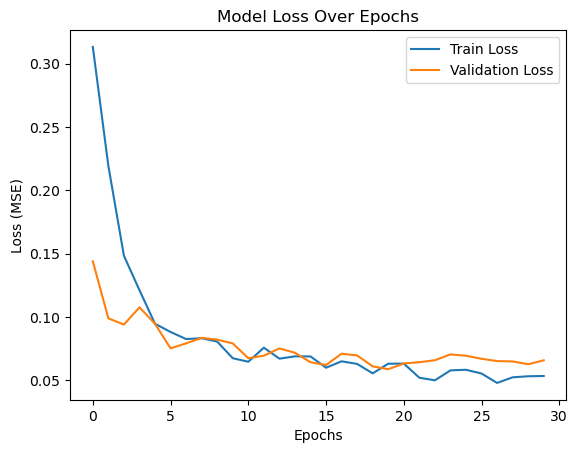

In [36]:
# Step 5: Plot Training History
# Plot loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Stage 4 Attempt 3: Regression Model

Random Forest Regression Mean Squared Error: 0.0427
Random Forest Regression R² Score: 0.4855


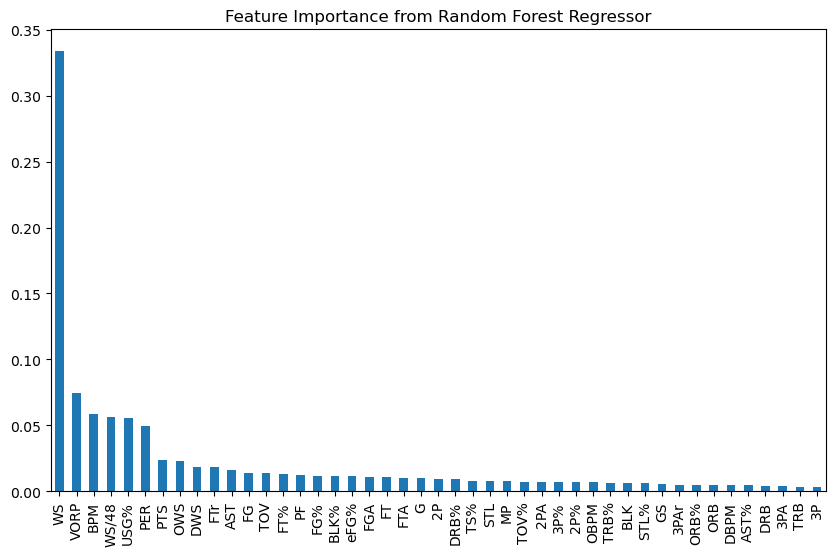

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    max_depth=10,      # Maximum depth of each tree
    random_state=42    # Ensures reproducibility
)

rf_regressor.fit(X_train_reg, y_train_reg)

# Step 2: Evaluate the Model
y_pred_rf = rf_regressor.predict(X_test_reg)

# Calculate metrics
mse_rf = mean_squared_error(y_test_reg, y_pred_rf)
r2_rf = r2_score(y_test_reg, y_pred_rf)

print(f"Random Forest Regression Mean Squared Error: {mse_rf:.4f}")
print(f"Random Forest Regression R² Score: {r2_rf:.4f}")

# Step 3: Analyze Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance
feature_importance = pd.Series(rf_regressor.feature_importances_, index=X_train_reg.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importance from Random Forest Regressor")
plt.show()


In [38]:
# Predicted values from the regression model
y_pred_rf = rf_regressor.predict(X_test_reg)

# Calculate the error (absolute difference between actual and predicted values)
error = abs(y_test_reg - y_pred_rf)

# Combine the original testing data, actual share values, predicted values, and error into a DataFrame
results_df = X_test_reg.copy()  # Start with the features from the test set
results_df['Actual_Share'] = y_test_reg.values
results_df['Predicted_Share'] = y_pred_rf
results_df['Error'] = error

# Sort the DataFrame by the 'Error' column in ascending order
results_df = results_df.sort_values(by='Error', ascending=True)

# Display the first few rows of the sorted results
print(results_df.head())

# Save the sorted results to a CSV file
results_df.to_csv("regression_results_sorted.csv", index=False)
print("Sorted results saved to 'regression_results_sorted.csv'.")


             G        GS        MP        FG       FGA       FG%        3P  \
1102  0.967611  1.158385  0.899341  1.383206  1.510376 -0.241858 -0.302352   
1704  0.648557  0.764342  0.710703  1.282498  1.014694  0.772223 -0.908952   
2679  0.705182  0.866842  0.998836  1.927429  1.729870  0.337428 -0.466773   
2835  0.558449  0.839911  1.264445  1.444835  1.663991 -0.768440  0.011389   
1308  0.782417  1.001009  0.430642  1.448713  1.187165  0.615022  0.726407   

           3PA       3P%        2P  ...       DWS        WS     WS/48  \
1102 -0.061811 -0.125554  1.596712  ...  0.464362  1.374540  0.915413   
1704 -0.793011 -1.429406  1.560125  ...  0.934255  1.492074  1.214870   
2679 -0.209588 -0.120514  2.239816  ...  0.917189  2.013880  1.624447   
2835  0.215203  0.191272  1.547894  ... -0.004127 -0.312886 -0.813548   
1308  0.645002  0.717954  1.109747  ... -0.130657  1.604002  1.537100   

          OBPM      DBPM       BPM      VORP  Actual_Share  Predicted_Share  \
1102  1.00018

# Stage 4 Attempt 4: Regression model via ride regression

In [41]:
# Step 1: Define and train the Ridge Regression model
ridge_regressor = Ridge(alpha=1.0, random_state=42)  # You can adjust alpha for regularization strength
ridge_regressor.fit(X_train_reg, y_train_reg)

# Step 2: Evaluate the model
y_pred_ridge = ridge_regressor.predict(X_test_reg)

# Calculate metrics
mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)
r2_ridge = r2_score(y_test_reg, y_pred_ridge)

print(f"Ridge Regression Mean Squared Error: {mse_ridge:.4f}")
print(f"Ridge Regression R² Score: {r2_ridge:.4f}")

# Step 3: Analyze Coefficients
# Combine feature names with coefficients for interpretation
ridge_coefficients = pd.Series(ridge_regressor.coef_, index=X_train_reg.columns)
print("Ridge Regression Coefficients:")
print(ridge_coefficients.sort_values(ascending=False))


Ridge Regression Mean Squared Error: 0.0394
Ridge Regression R² Score: 0.5247
Ridge Regression Coefficients:
WS       0.260511
PTS      0.190742
TOV%     0.152193
AST      0.135421
FT       0.103900
eFG%     0.096178
STL%     0.096131
3PAr     0.086805
BLK%     0.085443
USG%     0.070780
FG%      0.070542
FG       0.065050
BPM      0.059083
ORB      0.055173
WS/48    0.053575
3P       0.047931
TRB%     0.043863
OWS      0.042934
2PA      0.041327
DWS      0.026579
2P       0.026452
TRB      0.026244
DRB%     0.022204
VORP     0.001836
3PA     -0.021813
DBPM    -0.024026
FTr     -0.024416
G       -0.034594
3P%     -0.037617
FT%     -0.038172
DRB     -0.046785
FGA     -0.050507
TOV     -0.055663
2P%     -0.061856
FTA     -0.062065
PF      -0.068997
GS      -0.070951
BLK     -0.072476
AST%    -0.085373
ORB%    -0.087752
PER     -0.099027
STL     -0.109358
TS%     -0.162392
MP      -0.166744
OBPM    -0.189683
dtype: float64
